# Setup

In [ ]:
from typing import Union

import pandas as pd
import numpy as np
import warnings

import multiprocess

from allensdk.brain_observatory.behavior.behavior_project_cache import (
    VisualBehaviorNeuropixelsProjectCache,
)
import brain_observatory_utilities.datasets.behavior.data_formatting as behavior_utils

import utils
import os

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression
import sklearn.metrics as metrics

sns.set_palette("pastel")
warnings.filterwarnings("ignore")

# Random seed
SEED = 42

%matplotlib inline

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
session_id = int(os.environ["session_id"])
session_id

KeyError: 'session_id'

In [2]:
cache_dir = utils.get_data_root()
cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(
    cache_dir=cache_dir, use_static_cache=True
)

In [3]:
ephys_table = cache.get_ecephys_session_table()
ephys_table = ephys_table.loc[(~ephys_table["behavior_session_id"].isna()) & 
                              (ephys_table["experience_level"] == "Familiar")
                             ]
# session_id = ephys_table.index[0]
# From the behavior state notebook
# session_id_notebook = [1139846596, 1124507277, 1069461581]

# session_id_random = np.random.choice(ephys_table.index, 10)

unit_table = cache.get_unit_table()
probe_table = cache.get_probe_table()

In [4]:
# 1052342277 is probably an incorrect trial (someone may have knocked the rig): Send to Marina

In [5]:
# sessions = [cache.get_ecephys_session(session_id) for session_id in session_id_notebook]
# sessions = [cache.get_ecephys_session(session_id) for session_id in session_id_random]
sessions = [cache.get_ecephys_session(session_id)]

# Pull and filter data

In [6]:
def get_session_rates(
    session: VisualBehaviorNeuropixelsProjectCache, 
    smooth: bool = False,
    window: int = 20,
    cores: int = 16,
) -> pd.DataFrame:
    """Get firing rates averaged across stimulus presentations for all units in a session.
    
    Parameters
    ----------
    session
        Session object to draw spikes from
    smooth
        Whether or not to smooth the data using a rolling average.
        Default value is ``False``.
    window
        The size of the window for smoothing. Only used if smooth = ``True.``
        Default value is 20.
    cores
        Number of cores to for the parallelized operation of calculating spike rates.
        Default value is 16.
    
    Returns
    -------
    rates
        An (n, T+1) dataframe where the rows are individual units and the columns are
        firing rates at given firing rates. The last column is the brain region the unit
        is in. The number of time points is equal to the number of stimuli presentations
        during the active portion of a stimulus.
    """
    raw_times = session.spike_times
    session_units = session.get_units().join(unit_table["structure_acronym"])
    session_stimuli = session.stimulus_presentations
    session_stimuli = session_stimuli.loc[session_stimuli["active"]]
    trials = session.trials
    # trials = trials.loc[~trials["auto_rewarded"]]
    # session_stimuli = session_stimuli.loc[session_stimuli["trials_id"].isin(trials.index)]
    
    
    # Neural Encoding QC filters
    session_units = session_units[(session_units.isi_violations < 0.5) 
                    & (session_units.amplitude_cutoff < 0.1) 
                    & (session_units.presence_ratio > 0.9)
                                ]
    
    counts = np.zeros((session_units.shape[0], session_stimuli.shape[0]))
    rates = np.zeros((session_units.shape[0], session_stimuli.shape[0]))
    col_names = [f"t_{i}" for i in np.arange(session_stimuli.shape[0])]
    
    start_times, end_times = session_stimuli.start_time, session_stimuli.end_time
    pool = multiprocess.Pool(cores)

    def bin_spike_times(unit_id):
        unit_data = raw_times[unit_id]
        spike_times = [unit_data[(s1 < unit_data) & (unit_data <= s2)] - s1 for (s1, s2) in zip(start_times, end_times)]
        spike_rate = [float(spike_time_bin.shape[0]) for spike_time_bin in spike_times]/(end_times - start_times)
        
        window = 1 if not smooth else window
        spike_rate = np.convolve(spike_rate, np.ones(window), "same")/window
        
        return (unit_id, spike_rate)
    
    
    map_results = pool.map(bin_spike_times, session_units.index)
    spike_rates = {unit[0]: unit[1] for unit in map_results}
    spike_rates = dict(sorted(spike_rates.items())) 

    rates = pd.DataFrame.from_dict(spike_rates, orient="index", columns=col_names)
    rates["structure_acronym"] = session_units["structure_acronym"].values
    
    return rates

In [7]:
def get_behavior_state(
    session: VisualBehaviorNeuropixelsProjectCache, 
    window: int = 20, 
    hit_rate_thresh: float = 0.4
) -> np.array:
    """Get the behavior states based on a rolling mean of the hit rate. This is over all time points and intended to line up
    with the session_rates data.
    
    Parameters
    ----------
    session
        The session to get behavioral states from.
    window
        The size of the rolling average used to determine behavior states.
        Default value is 20.
    hit_rate_thresh
    The threshold to categorize behavioral states.
        Default value is 0.4.

    Returns
    -------
    behavior_state
        A binary vector of length T (Number of stimulus presentations in the active session).
        A value of 1 indicates attentive state, a value of 0 indicates not attentive. A value
        of ``np.nan`` indicates that the trial the stimulus presentations was a no-go trial.
    """
    trials = session.trials
    # trials = trials.loc[~trials["auto_rewarded"]]
    hit_rate = trials.hit[trials.go].rolling(window).mean()
    hits = (
        (session_stimuli := session.stimulus_presentations).reset_index().loc[session_stimuli["active"], ["stimulus_presentations_id", "trials_id"]].merge(
            hit_rate, left_on="trials_id", right_index=True).reset_index(drop=True)
    )
    behavior_state = np.zeros(session_stimuli.loc[session_stimuli["active"]].shape[0])
    behavior_state[:] = np.nan
    behavior_state[hits.stimulus_presentations_id] = (hits["hit"] > hit_rate_thresh) * 1
    
    return behavior_state

In [8]:
def filter_go_trials(session_rates: pd.DataFrame, behavior_state: np.array) -> tuple[pd.DataFrame, np.array]:
    """Filter out no-go trials.
    
    Parameters
    ----------
    session_rates
        Session firing rates to filter.
    behavior_state
        Behavior state array to use as basis to filter and to filter.
    
    Returns
    -------
    session_rates
        The filtered session firing rates.
    behavior_state
        The filtered behavior state array.
    """
    go_idx = np.argwhere(~np.isnan(behavior_state))
    behavior_state = behavior_state[go_idx]
    # Preserve structure_acronym
    go_idx = np.append(go_idx, session_rates.shape[1]-1)
    session_rates = session_rates.iloc[:, go_idx]
    return session_rates, behavior_state

# Activity by Region

## Pull data

In [9]:
session_rates = [get_session_rates(session) for session in sessions]

In [10]:
behavior_states = [get_behavior_state(session) for session in sessions]

In [304]:
def plot_areas(
    session_rates: pd.DataFrame, 
    behavior_state: np.array, 
    areas: Union[str, list[str]] = None, 
    go_only: bool = False,
):
    """
    Plot the mean activity of a brain region along with individual unit activity along with
    behavioral state.
    
    If no areas are provided, all areas will be plotted.
    
    Parameters
    ----------
    session_rates
        The firing rates to plot.
    behavior_state
        The behavior state vector to plot.
    areas
        Single or list of brain regions to plot.
        Default behavior is to plot all regions
    go_only
        Whether to filter non-go trials. Default value is to not filter.
    
    Returns
    -------
    fig, ax
        Matplotlib plot
    """
    if areas is None:
        areas = session_rates["structure_acronym"].unique()
    elif isinstance(areas, str):
        areas = [areas]
    
    fig, axes = plt.subplots(len(areas), 2, figsize=(16, 6 * len(areas)));
        
    axes = np.expand_dims(axes, 0) if len(areas) == 1 else axes
    
    if go_only:
        session_rates, behavior_state = filter_go_trials(session_rates, behavior_state)
    
    session_rates_t = session_rates.iloc[:, :-1].T
    
    for i, area in enumerate(areas):
        area_activity_idx = session_rates.loc[session_rates["structure_acronym"] == area].index
        (area_rates := session_rates_t.loc[:, area_activity_idx]).mean(axis=1).plot(ax=axes[i,0]);
        

        axes[i, 0].set_title(f"(mean) activity for {area}");
        axes[i, 0].plot(behavior_state, linewidth=3);
        axes[i, 0].set_ylabel("Firing rate (over stimulus presentation")
        
        area_rates.plot(ax=axes[i,1], alpha=0.4);
        axes[i, 1].plot(behavior_state * area_rates.to_numpy().max(axis=(0,1))/5, color="orange", linewidth=3);
        axes[i, 1].set_title(f"activity for {area}");
        axes[i, 1].legend().remove();
        
    fig.tight_layout();
    return fig, axes

In [305]:
def plot_area_units(
    session_rates: pd.DataFrame, 
    behavior_state: np.array, 
    area: str, 
    go_only: bool = False,
) -> None:
    """
    Plot the individual unit activity for a single brain region.
        
    Parameters
    ----------
    session_rates
        The firing rates to plot.
    behavior_state
        The behavior state vector to plot.
    area
        Region to plot units for.
    go_only
        Whether to filter non-go trials. Default value is to not filter.
    
    Returns
    -------
    fig, ax
        Matplotlib plot
    """
    if go_only:
        session_rates, behavior_state = filter_go_trials(session_rates, behavior_state)
    
    area_rates = session_rates.loc[session_rates["structure_acronym"] == area]
    
    area_rates_t = area_rates.iloc[:, :-1].T
    fig, axes = plt.subplots((n_units := area_rates_t.shape[1]), 1, figsize=(16, 6 * n_units), sharex=True);
    axes = np.reshape(axes, -1) if n_units == 1 else axes
    for i, ax in enumerate(axes):
        area_rates_t.iloc[:, i].plot(ax=ax)
        ax.plot(behavior_state * area_rates_t.iloc[:, i].to_numpy().max(axis=(0))/5, color="orange", linewidth=3);
        ax.set_title(f"activity for {area_rates_t.columns[i]}");
        ax.set_ylabel("Firing rate (over stimulus presentation")


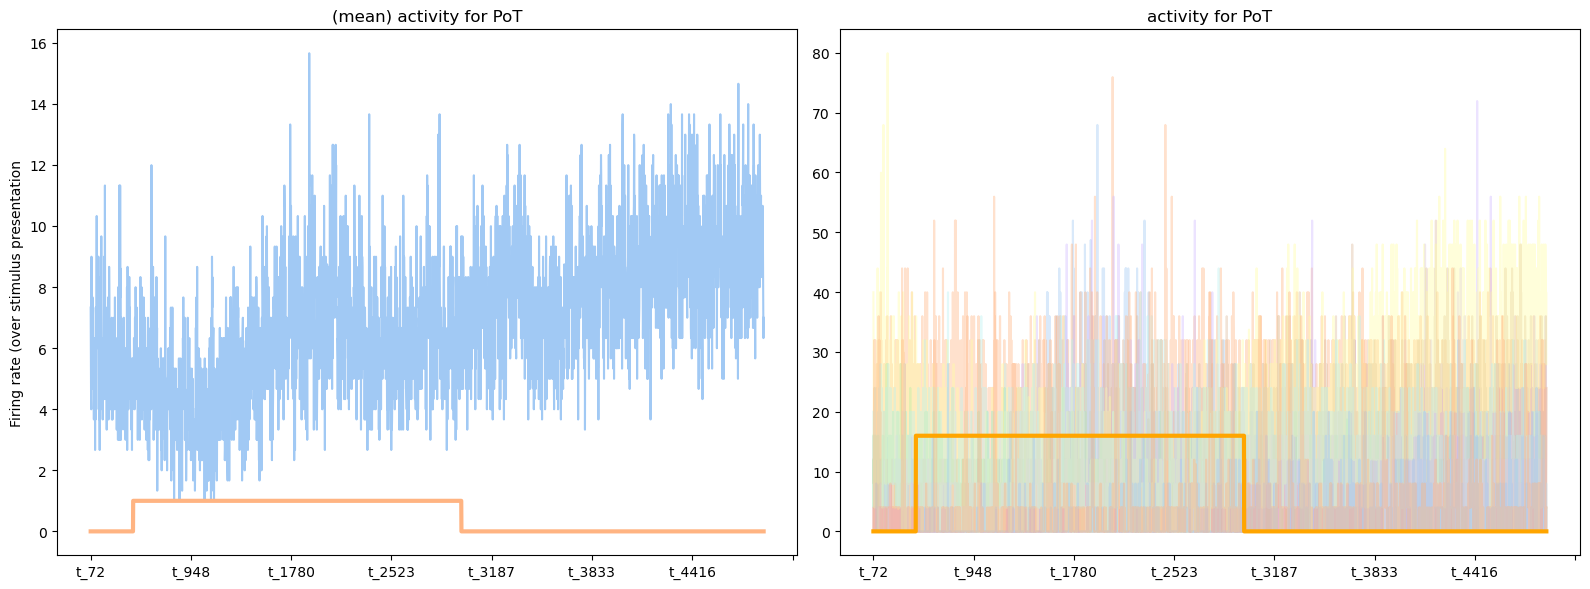

In [425]:
plot_areas(session_rates[0], behavior_states[0], areas="PoT", go_only=True);

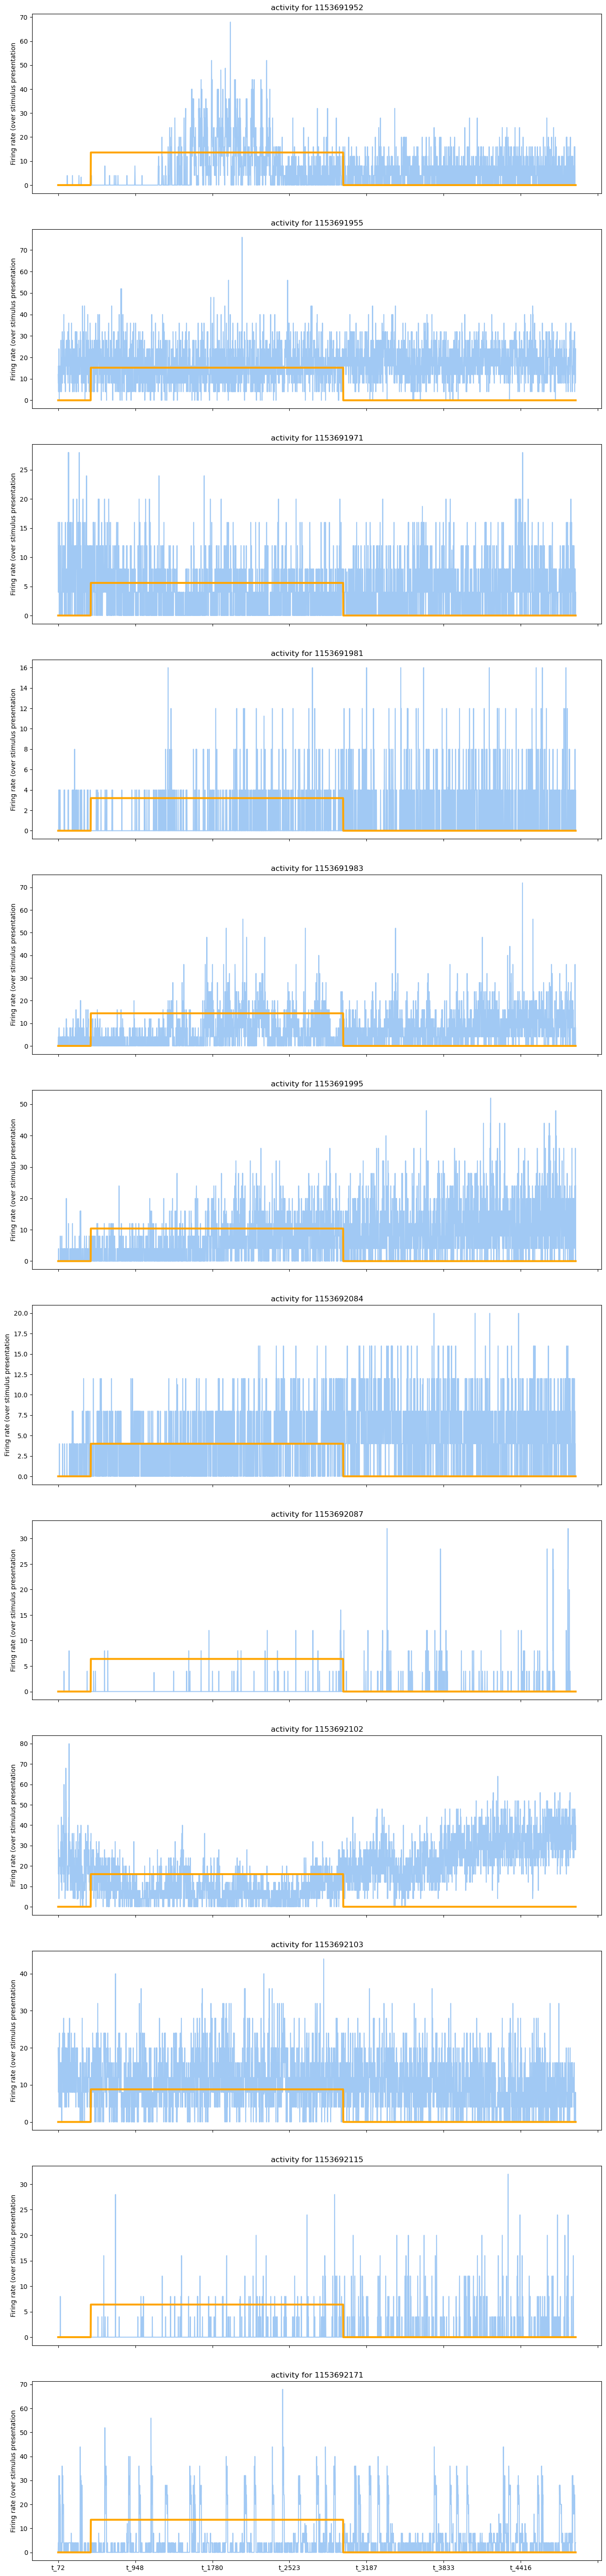

In [426]:
plot_area_units(session_rates[0], behavior_states[0], "PoT", go_only=True);

# Logistic Regression

## Binary Classification using Population Averages

In [140]:
X, y = filter_go_trials(session_rates[0], behavior_states[0])
y = y.squeeze()
X_region = X.groupby("structure_acronym").mean().T
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [329]:
region_lr = LogisticRegression(C=0.01, class_weight="balanced", random_state=SEED)
f_stats_region = pd.DataFrame({"area": X_region.columns, "F_value": np.zeros(X_region.shape[1]), "p_value": np.zeros(X_region.shape[1])})

for train_idx, test_idx in skf.split(X_region, y):
    X_train, X_test, y_train, y_test = X_region.iloc[train_idx], X_region.iloc[test_idx], y[train_idx], y[test_idx]
    
    region_lr.fit(X_train, y_train)
    y_pred = region_lr.predict(X_test)
    
    # print(metrics.classification_report(y_test, y_pred))
    # print(metrics.confusion_matrix(y_test, y_pred))
    # print(metrics.f1_score(y_test, y_pred))
    f_value, p_value = f_regression(X_test, y_test)
    f_stats_region["F_value"] += f_value/5
    f_stats_region["p_value"] += p_value/5


region_lr.fit(X_region, y)
regional_coef = pd.DataFrame({"area": X["structure_acronym"].unique(), "coefs": region_lr.coef_[0]}).sort_values("area")

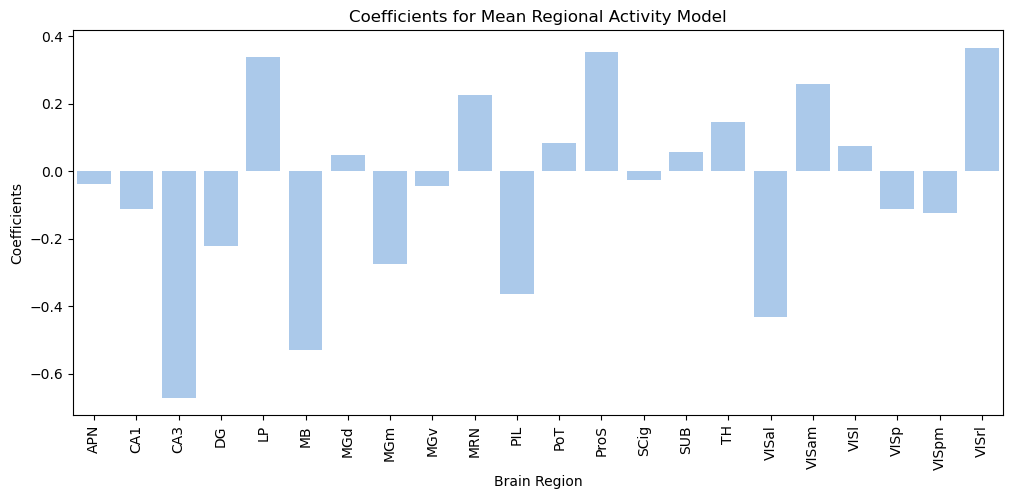

In [358]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=regional_coef, x="area", y="coefs", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center');
ax.set_xlabel("Brain Region");
ax.set_ylabel("Coefficients")
ax.set_title("Coefficients for Mean Regional Activity Model");

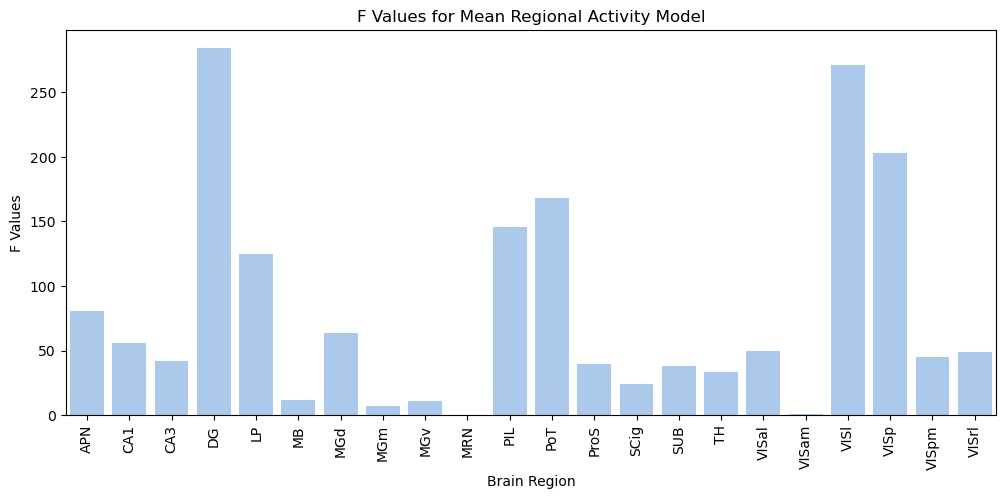

In [359]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=f_stats_region, x="area", y="F_value", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center');
ax.set_xlabel("Brain Region");
ax.set_ylabel("F Values")
ax.set_title("F Values for Mean Regional Activity Model");

In [331]:
f_stats_region[f_stats_region["p_value"] < 0.5]

,area,F_value,p_value
0,APN,80.874414,1.372318e-16
1,CA1,56.176267,2.716926e-10
2,CA3,41.529498,4.707502e-07
3,DG,283.934068,1.403371e-49
4,LP,124.933845,2.529309e-18
5,MB,11.520723,8.933442e-03
6,MGd,63.809597,9.288099e-12
7,MGm,6.794149,7.615664e-02
8,MGv,10.804578,4.427603e-02
10,PIL,145.668062,9.115004e-26


In [291]:
f_stats_region[f_stats_region["p_value"] > 0.05]

,area,F_value,p_value
7,MGm,6.794149,0.076157
9,MRN,0.459402,0.587703
17,VISam,0.958284,0.529559


## Binary Classification (for each Region) Using Unit Activity 

In [176]:
roi = f_stats_region.loc[f_stats_region["p_value"] < 0.5, "area"]
unit_lr = [LogisticRegression(C=0.01, class_weight="balanced", random_state=SEED)] * roi.shape[0]

In [410]:
f_stats_unit = pd.DataFrame({"area": [], "unit": [], "F_value": [], "p_value": []})
# Iterate over all regions
for i, (lr, area) in enumerate(zip(unit_lr, roi)):
    X_unit = X.loc[X["structure_acronym"] == area]
    X_unit = X_unit.iloc[:, :-1].T
    y_unit = y[X_unit.reset_index().index]
    f_stats_area = pd.DataFrame({
        "area": [area] * X_unit.shape[1],
        "unit": np.zeros(X_unit.shape[1], dtype=int), 
        "F_value": np.zeros(X_unit.shape[1]), 
        "p_value": np.zeros(X_unit.shape[1])
    })
    f_stats_area.unit = X_unit.columns.astype(int)
    # Iterate over folds
    for train_idx, test_idx in skf.split(X_unit, y_unit):
        X_train, X_test, y_train, y_test = X_unit.iloc[train_idx], X_unit.iloc[test_idx], y_unit[train_idx], y_unit[test_idx]
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        # print(metrics.classification_report(y_test, y_pred))
        # print(metrics.confusion_matrix(y_test, y_pred))
        # print(metrics.f1_score(y_pred, y_test))
        f_value, p_value = f_regression(X_test, y_test)
        
        f_stats_area.F_value += f_value
        f_stats_area.p_value += p_value
    
    f_stats_unit = pd.concat([f_stats_unit, f_stats_area])

f_stats_unit.index = f_stats_unit["unit"]

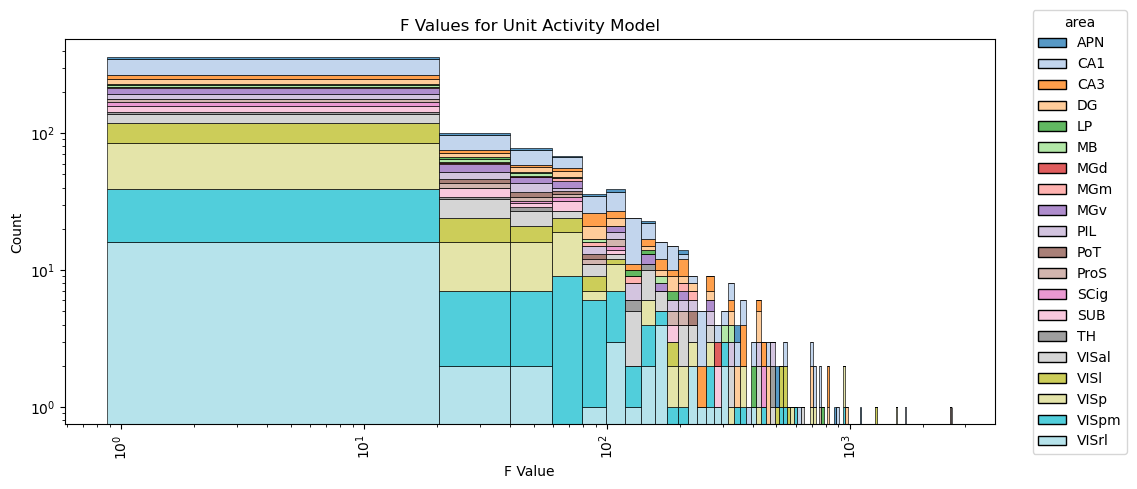

In [429]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=f_stats_unit, x="F_value", hue="area", stat="count", palette="tab20", multiple="stack", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center');
ax.set_xlabel("F Value");
ax.set_ylabel("Count")
ax.set_title("F Values for Unit Activity Model");
ax.set_yscale("log")
ax.set_xscale("log")
sns.move_legend(ax, "center right", bbox_to_anchor=(1.15, 0.5));

### Filter out regions with bottom 10% of units

In [412]:
lower_q_unit_count = f_stats_unit.groupby("area").count().quantile(.1)["unit"]
f_stats_unit_filtered = f_stats_unit.loc[f_stats_unit.groupby('area')['unit'].transform('size') > lower_q_unit_count]

### Grab the units from each area with the top 10% F score

In [413]:
f_stats_top_units = f_stats_unit_filtered.loc[
    f_stats_unit_filtered["F_value"] > (
        f_stats_unit_filtered.groupby("area")["F_value"].transform("quantile", 0.9)
    )
]

In [415]:
filtered_roi = f_stats_top_units.area.unique()
filtered_unit_lr = [LogisticRegression(C=0.01, class_weight="balanced", random_state=SEED)] * filtered_roi.shape[0]

In [428]:
f_stats_unit_top_q = pd.DataFrame({"area": [], "unit": [], "F_value": [], "p_value": []})
X_filtered = X.iloc[X.index.isin(f_stats_top_units.index)]
                        
for i, (lr, area) in enumerate(zip(filtered_unit_lr, filtered_roi)):
    print(area)
    X_unit = X_filtered.loc[X["structure_acronym"] == area]
    X_unit = X_unit.iloc[:, :-1].T
    y_unit = y[X_unit.reset_index().index]
    f_stats_area = pd.DataFrame({
        "area": [area] * X_unit.shape[1],
        "unit": np.zeros(X_unit.shape[1], dtype=int), 
        "F_value": np.zeros(X_unit.shape[1]), 
        "p_value": np.zeros(X_unit.shape[1])
    })
    f_stats_area.unit = X_unit.columns
    for train_idx, test_idx in skf.split(X_unit, y_unit):
        X_train, X_test, y_train, y_test = X_unit.iloc[train_idx], X_unit.iloc[test_idx], y_unit[train_idx], y_unit[test_idx]
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        # print(metrics.classification_report(y_test, y_pred))
        # print(metrics.confusion_matrix(y_test, y_pred))
        print(metrics.f1_score(y_test, y_pred))
        f_value, p_value = f_regression(X_test, y_test)
        f_stats_area.F_value += f_value
        f_stats_area.p_value += p_value
        
    filtered_unit_lr[i] = lr.fit(X_unit, y_unit)   
    f_stats_unit_top_q = pd.concat([f_stats_unit_top_q, f_stats_area])

f_stats_unit_top_q.index = f_stats_unit_top_q.unit.astype(int)

APN
0.784251968503937
0.8056426332288401
0.8
0.7665056360708534
0.7806451612903226
CA1
0.8819133034379671
0.8892171344165436
0.9054878048780488
0.9131075110456554
0.8921713441654358
CA3
0.7690014903129657
0.7807807807807807
0.7507598784194529
0.7583081570996979
0.7576687116564417
DG
0.8059701492537313
0.827893175074184
0.804915514592934
0.8138138138138138
0.8042488619119879
MB
0.6698113207547169
0.6064516129032258
0.6019736842105263
0.6268656716417911
0.6047244094488189
MGm
0.6843434343434344
0.6822660098522167
0.6957605985037406
0.6788766788766789
0.6851385390428212
MGv
0.7119155354449472
0.6728971962616822
0.699523052464229
0.7186544342507645
0.6927710843373494
PIL
0.7794117647058824
0.7777777777777778
0.7824817518248175
0.7488721804511278
0.7406296851574213
PoT
0.7976011994002998
0.7945205479452054
0.8198198198198198
0.8296296296296296
0.8392857142857143
ProS
0.7230320699708455
0.717201166180758
0.7240356083086054
0.7474747474747475
0.7225433526011561
SCig
0.6820143884892086
0.69309

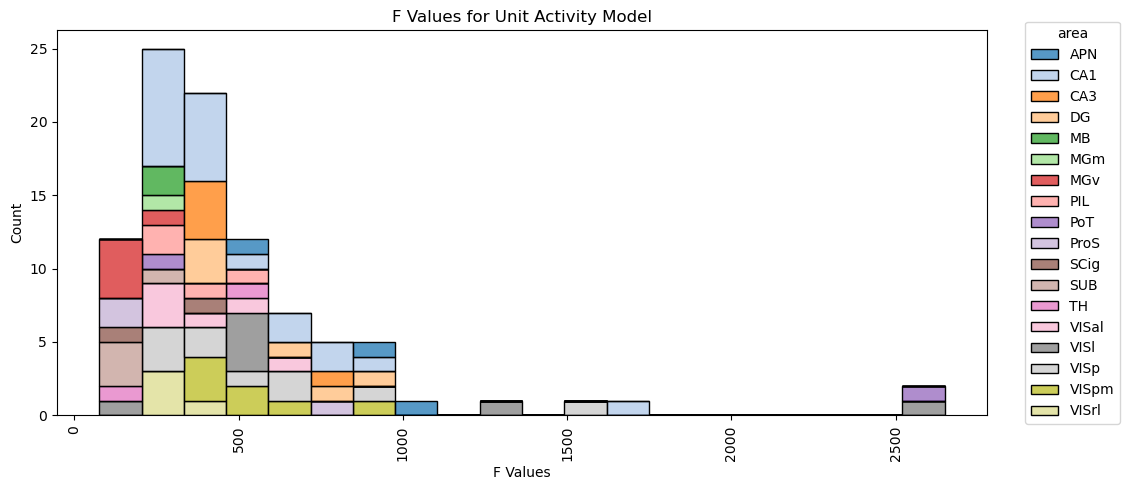

In [424]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=f_stats_unit_top_q, x="F_value", hue="area", stat="count", palette="tab20", multiple="stack", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center');
ax.set_xlabel("F Values");
ax.set_ylabel("Count")
ax.set_title("F Values for Unit Activity Model");
sns.move_legend(ax, "center right", bbox_to_anchor=(1.15, 0.5));